### Import modules

In [1]:
%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import base wavefront and beamline class
from wpg import Wavefront, Beamline

# import base OE wrappers
from wpg.optical_elements import Aperture, Drift, CRL, Empty, Use_PP

# Gaussian beam generator
from wpg.generators import build_gauss_wavefront

#import SRW core functions
from wpg.srwlib import srwl, srwl_opt_setup_CRL, SRWLOptD, SRWLOptA, SRWLOptC, SRWLOptT, SRWLOptCryst


#import some helpers functions
from wpg.wpg_uti_wf import propagate_wavefront, plot_t_wf, get_intensity_on_axis
from wpg.wpg_uti_oe import show_transmission

plt.ion()

### Define auxiliary functions

In [3]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011

    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * np.sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

def _save_object(obj, file_name):
    """
    Save any python object to file.

    :param: obj : - python objest to be saved
    :param: file_name : - output file, wil be overwrite if exists
    """
    with open(file_name,'wb') as f:
        pickle.dump(obj, f)

def _load_object(file_name):
    """
    Save any python object to file.

    :param: file_name : - output file, wil be overwrite if exists
    :return: obj : - loaded pthon object
    """
    res = None
    with open(file_name,'rb') as f:
        res = pickle.load(f)

    return res

def mkdir_p(path):
    """
    Create directory with subfolders (like Linux mkdir -p)

    :param path: Path to be created
    """
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise


### Defining initial wavefront and writing electric field data to h5-file

compare pulse duration to see if dispersion gets larger
    1 fs
    5 fs
    10 fs
    
///one dimensional focusing

pick 5fs case and pad more 0's around the beam (increase fov of source)
double number of time slice

Need to confirm:
    after focus, if longer pulse -> monochromatic, vertical beam size becomes smaller
    
for each condition, double nz to see if result looks the same

*****defining initial wavefront and writing electric field data to h5-file...
sigX, waist_fwhm [um], far field theta_fwhms [urad]: 11.499788231945866, 27.079931842197144,2.9970290603902483


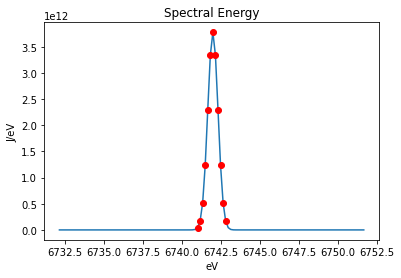

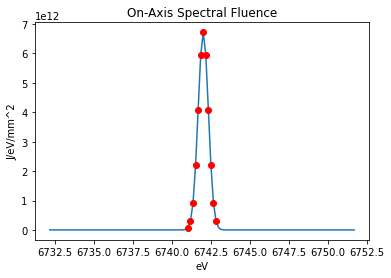

number of meaningful slices: 12
R-space
(2000,) (2000,)
FWHM in x = 7.035e-04 m.
FWHM in y = 7.035e-04 m.


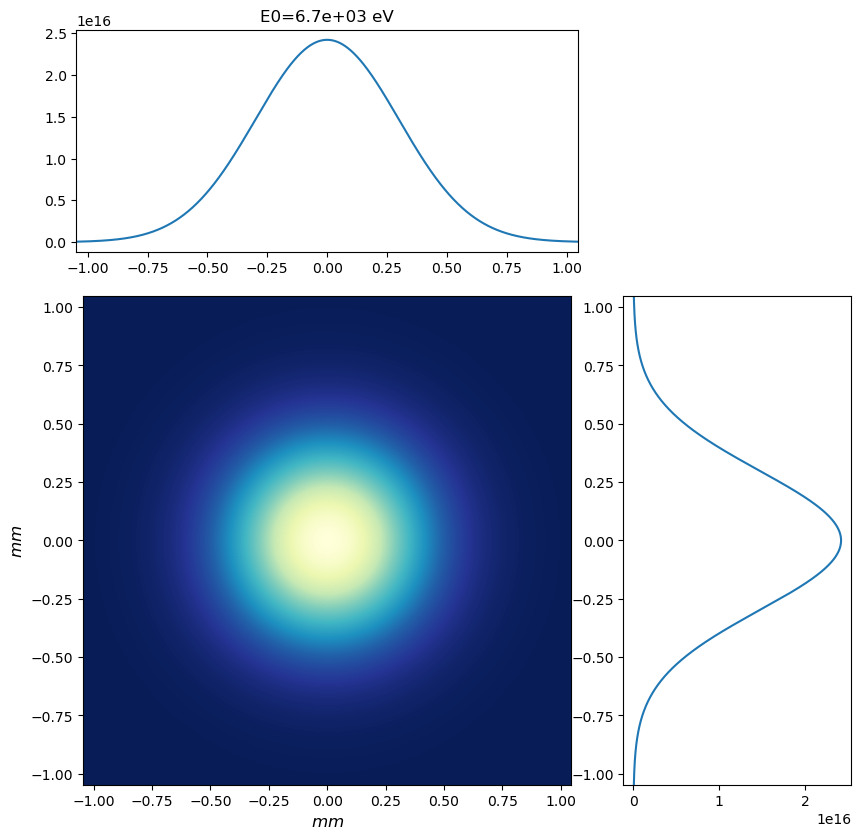

6732.1571121235 6751.678839745226


In [39]:
print('*****defining initial wavefront and writing electric field data to h5-file...')
strDataFolderName = 'WPG_output/temporal/' # output data sub-folder name
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

ekev = 6.742 # Energy [keV]
thetaOM = 2.5e-3       # @check!

# e-bunch charge, [nC]; total pulse energy, J
#qnC = 0.02;pulse_duration = 1.7e-15;pulseEnergy = 0.08e-3
#coh_time = 0.24e-15

qnC = 0.1; # e-bunch charge, [nC]
#pulse_duration = 9.e-15;
pulse_duration = 1.e-15;
pulseEnergy = 0.5e-3; # total pulse energy, J
coh_time = pulse_duration
''' distance to first OE '''
z1 = 235.0

theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm)
print('sigX, waist_fwhm [um], far field theta_fwhms [urad]: {}, {},{}'.format(
                            sigX*1e6, sigX*k*1e6, theta_fwhm*1e6)
      )
#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size
#range_xy = range_xy*2
''' input dimensions '''
npoints=2000
pulseRange = 25
#nz = int(np.floor(pulseRange*pulse_duration/coh_time))
nz = 120

wfr0 = build_gauss_wavefront(npoints, npoints, nz, ekev, -range_xy/2, range_xy/2,
                                -range_xy/2, range_xy/2 ,pulse_duration, sigX, sigX, z1,
                                pulseEn=pulseEnergy,pulseRange=pulseRange)

mwf = Wavefront(wfr0)

# input spectrum
srwl.SetRepresElecField(mwf._srwl_wf, 'f')
plot_t_wf(mwf)
eStart = mwf._srwl_wf.mesh.eStart
eFin = mwf._srwl_wf.mesh.eFin
print(eStart, eFin)
srwl.SetRepresElecField(mwf._srwl_wf, 't')
mwf_backup = copy.deepcopy(mwf)

dirname_duration = strDataFolderName+'{}fs_beam_nz={}/'.format(round(pulse_duration*1e15,1),nz)
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

In [40]:
dirname_duration

'WPG_output/temporal/1.0fs_beam_nz=120/'

In [41]:
import imageio

print('{} slices'.format(nz))
dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
        mkdir_p(dirname_input)
        
# plot incident beam
cmin = (mwf.get_intensity()).min()
cmax = (mwf.get_intensity()).max()

[xmin, xmax, ymin, ymax] = mwf.get_limits()
intensity_all = mwf.get_intensity().sum()

plt.figure()
for islice in range(nz):
    intensity_slice = mwf.get_intensity(slice_number=islice)
    plt.imshow(intensity_slice,cmap='jet',clim=(cmin,cmax),
              extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
    plt.colorbar()
    plt.title('slice {}/{}, intensity {}%'.format(islice,nz-1,np.floor(100*intensity_slice.sum()/intensity_all)))
    plt.xlabel('x (mm)')
    plt.ylabel('y (mm)')
    filename = dirname_input+'slice{}.png'.format(islice)
    plt.savefig(filename)
    plt.clf()

# make gif
with imageio.get_writer(dirname_input+'beam.gif', mode='I', duration=0.3) as writer:
    for islice in range(nz):
        filename = dirname_input+'slice{}.png'.format(islice)
        image = imageio.imread(filename)
        writer.append_data(image)



120 slices
R-space


<Figure size 432x288 with 0 Axes>

### Defining optical beamline(s) 

In [42]:
%autoreload 2
from Optics import *
''' aperture '''
Apt = Aperture('r','a',50e-6)

''' crystal parameters '''
d_sp = 3.13557135638           # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05     # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06      # imaginary part of ""
psi_hr = -2.71341902391e-05    # real part of Hth Fourier component
psi_hi = 2.50565837652e-06     # imaginary part of ""
psi_hbr = -2.71341902391e-05   # real part of -Hth Fourier component
psi_hbi = 2.50565837652e-06    # imaginary part of ""
tc = 0.01                      # crystal thickness
ang_as = -np.deg2rad(5)        # asymmetric angle
uc = 1                         # use case: 1 (Bragg reflection); 2 (Bragg transmission)
#ang = 0.83257236543
#amp_coef = 1.0

OE_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' crystal orientation '''
ang_dif_pl = 0                # diffraction plane angle: 0 (vertical); pi/2 (horizontal)

# outward normal vector to crystal surface
nvx, nvy, nvz = OE_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]

# central tangential vector
tvx, tvy, _ = OE_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][0]

OE_Crystal.set_orient(nvx,nvy,nvz,tvx,tvy)

''' lens parameter '''
n = 1 - 5.89e-6           # material refractive index
d_abs = 788e-6        # material absorption depth

nx = 2000
ny = 2000
Lens_width = 5e-3
f_lens = 3.0

Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(nx,ny,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=eStart,_eFin=eFin)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,nx)
Lens_y = np.linspace(-Lens_width/2,Lens_width/2,ny)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_y)

Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)

Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)


### Propagation

In [43]:
''' Propagation distance '''
z2 = 1
z3 = f_lens

''' WPG '''
optBL0 = Beamline()
#optBL0.append(Apt, Use_PP(semi_analytical_treatment=0))
optBL0.append(OE_Crystal, Use_PP(semi_analytical_treatment=0))
optBL0.append(Drift(z2),  Use_PP(semi_analytical_treatment=0,zoom=1))
optBL0.append(Lens_Apt,   Use_PP(semi_analytical_treatment=0))
optBL0.append(Lens_Tr,    Use_PP(semi_analytical_treatment=0))
optBL0.append(Drift(z3),  Use_PP(semi_analytical_treatment=0))

optBL = optBL0
bl = optBL

startTime = time.time()
srwl.SetRepresElecField(mwf._srwl_wf, 'f') # <---- switch to frequency domain
bl.propagate(mwf)
srwl.SetRepresElecField(mwf._srwl_wf, 't')
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))



propagation lasted: 4.6 min


R-space
R-space
(-0.0010473367390211922, 0.0010462894022821713, 0.0005821310057618634, -0.0005827137194813447)


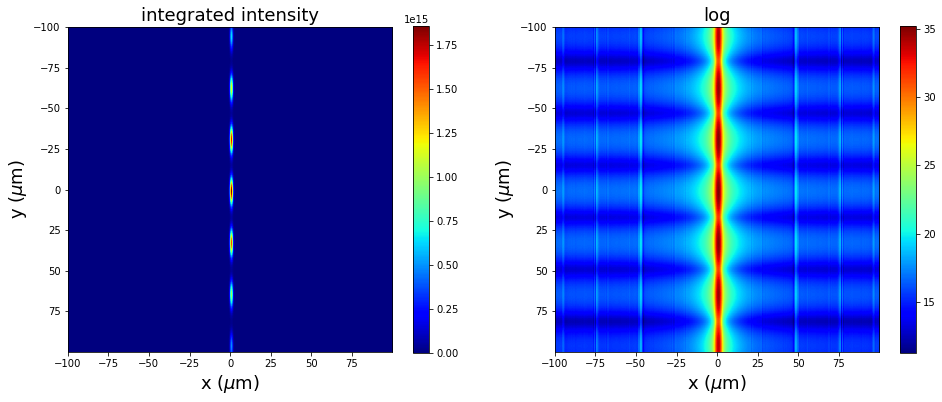

<Figure size 432x288 with 0 Axes>

In [44]:
''' plot zoom in '''
dirname_prop = dirname_duration+'propagation_{}m/'.format(z2)
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

# plot integrated intensity
[xmin, xmax, ymin, ymax] = mwf.get_limits()
print(mwf.get_limits())
d_fov = 200e-6

roi_ratio_x = np.abs(d_fov/(xmax-xmin))
roi_ratio_y = np.abs(d_fov/(ymax-ymin))
roixi = int(nx*(1-roi_ratio_x)/2); roixf = int(nx*(1+roi_ratio_x)/2)
roiyi = int(ny*(1-roi_ratio_y)/2); roiyf = int(ny*(1+roi_ratio_y)/2)

xlimi = xmin*roi_ratio_x; xlimf = xmax*roi_ratio_x
ylimi = ymin*roi_ratio_y; ylimf = ymax*roi_ratio_y

intensity_det = mwf.get_intensity().sum(axis=-1)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.imshow(intensity_det[roixi:roixf,roiyi:roiyf], cmap='jet',
          extent = [xlimi*1e6, xlimf*1e6, ylimi*1e6, ylimf*1e6])
plt.colorbar()
plt.title('integrated intensity',fontsize=18)
plt.xlabel(r'x ($\mu$m)',fontsize=18)
plt.ylabel(r'y ($\mu$m)',fontsize=18)

plt.subplot(1,2,2)
plt.imshow(np.log(intensity_det)[roixi:roixf,roiyi:roiyf], cmap='jet',
          extent = [xlimi*1e6, xlimf*1e6, ylimi*1e6, ylimf*1e6])
plt.colorbar()
plt.title('log',fontsize=18)
plt.xlabel(r'x ($\mu$m)',fontsize=18)
plt.ylabel(r'y ($\mu$m)',fontsize=18)

plt.savefig(dirname_prop+'integrated_intensity.png')

# plot propagated beam (slices)
cmin = (mwf.get_intensity()).min()
cmax = (mwf.get_intensity()).max()

intensity_all = mwf.get_intensity().sum()
plt.figure()
for islice in range(nz):
    intensity_slice = mwf.get_intensity(slice_number=islice)
    plt.imshow(intensity_slice[roixi:roixf,roiyi:roiyf],cmap='jet',clim=(cmin,cmax),
              extent = [xlimi*1e6, xlimf*1e6, ylimi*1e6, ylimf*1e6])
    plt.colorbar()
    plt.title('slice {}/{}, intensity {}%'.format(islice,nz-1,np.floor(100*intensity_slice.sum()/intensity_all)),fontsize=18)
    plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel(r'y ($\mu$m)',fontsize=18)
    filename = dirname_prop+'slice{}.png'.format(islice)
    plt.savefig(filename)
    plt.clf()

# make gif
with imageio.get_writer(dirname_prop+'beam.gif', mode='I', duration=0.3) as writer:
    for islice in range(nz):
        filename = dirname_prop+'slice{}.png'.format(islice)
        image = imageio.imread(filename)
        writer.append_data(image)


R-space


Text(0, 0.5, 'y (mm)')

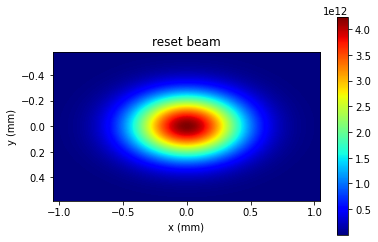

In [45]:
''' reset beam '''
mwf = copy.deepcopy(mwf_backup)
[xmin, xmax, ymin, ymax] = mwf.get_limits()
plt.figure()
plt.imshow(mwf.get_intensity().sum(axis=-1),cmap='jet',
          extent = [xmin*1e3, xmax*1e3, ymin*1e3, ymax*1e3])
plt.colorbar()
plt.title('reset beam')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')

